In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
from statsmodels import robust
import math
import datetime

import arviz as az
import pymc3 as pm

from numpy.random import default_rng


pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 120)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199


metadata_unfiltered = pd.read_csv("drive/MyDrive/Dissertation/uganda_airquality_dataset/site-registry.csv")
metadata =  pd.read_csv("drive/MyDrive/Dissertation/uganda_airquality_dataset/site-registry.csv")
#metadata = metadata_unfiltered.drop(labels=[76,77,83,25,60,47,63,69,2,24,31,26,17,32,73], axis=0)
plt.rcParams["figure.figsize"] = (20,10)

ids = metadata["generated_name"]
distances_road = metadata["distance_to_nearest_road"]

sites = [
"Bahai, Kawempe.csv","Banda, Kampala.csv",
"Bbuto, Kira Municipality.csv","Bududa Town Council, Bududa.csv","Bugana, Namayingo.csv",
"Bugolobi, Nakawa.csv","Bukasa, Kira Municipality.csv","Bukikali,Lwaso Mbale.csv",
"Bukoto I, Kawempe.csv","Buloli North, Bududa.csv","Bumurwa, Namisindwa.csv","Busabala, Wakiso.csv",
"Busega, Rubaga.csv","Busembatya, Iganga.csv","Butabika, Nakawa.csv",
"Bweyogerere, Kira Municipality.csv","Bweyogerere, Wakiso.csv",
"Bwole Ward, Bugiri.csv","Central Division, Tororo.csv","Chekwanda, Kapchorwa.csv",
"City Council, Jinja.csv","Civic Centre, Kampala Central.csv","Eastern Division, Busia.csv",
"Ggulu Ward, Mukono.csv","Jinja Main Street, Jinja.csv","Kabale Town, Kabale.csv",
"Kalerwe, Kawempe.csv","Kasenge, Wakiso.csv","Kasharara, Rubirizi.csv",
"Kasubi, Rubaga.csv","Katende Ward, Jinja.csv","Kawempe Industrial, Kawempe.csv",
"Kichinjanji, Soroti.csv","Kimaka, Jinja.csv",
"Kisanga, Kasese.csv","Kisugu, Makindye.csv","Kitukutwe, Kira Municipality.csv",
"Kiwatule, Nakawa.csv","Kyabirwa Namizzi, Jinja.csv","Kyaliwajala, Kira Municipality.csv",
"Kyanja, Nakawa.csv","Kyebando, Kampala.csv","Kyebando, Kawempe.csv",
"Lower Nsooba, Kawempe.csv","Lubanga Road, Mubende.csv","Lukuli, Makindye.csv",
"Luwafu, Makindye.csv","makerere university weather station.csv",
"Makindye, Lukuli Makindye.csv","Masaba, Mbale Industrial division.csv",
"Mbalwa, Kira Municipality.csv","Mbarara Central.csv","Mbarara University, Mbarara.csv",
"Mbuya II, Nakawa.csv","Mpererwe, Kawempe.csv","Mutundwe, Makindye Ssabagabo.csv",
"Naguru II, Nakawa.csv","Najera, Kira Municipality.csv",
"Nakasero II A, Kampala.csv","Nakasero II B, Kampala.csv","Nansana east ward, Wakiso.csv",
"Nansana west ward, Wakiso.csv","Nantabulirwa ward, Mukono.csv","Nkaatu, Iganga.csv",
"NsambyaUS Embassy Makindye.csv","Nsasa, Kira Municipality.csv","Nsawo, Kira Municipality.csv",
"Ntinda, Nakawa.csv","Nyahuka, Bundibugyo.csv","Nyendo, Masaka.csv",
"Rubaga, Kampala.csv","Rwengoma, Kabarole.csv","Town Centre, Kasese.csv",
"Walukuba East, Jinja City.csv","Wobulenzi west, Luwero.csv"]

metadata.loc[68,"name"]="Nakasero II A, Kampala"
metadata.loc[69,"name"]="Nakasero II B, Kampala"
metadata.loc[55,"name"]="NsambyaUS Embassy Makindye"
metadata.loc[80,"name"]="makerere university weather station"
metadata.loc[2,"distance_to_nearest_road"]= 56.6

In [76]:
#Getting the distance from city centre for all sites
distances_from_nearest_road = {}
for site in sites:
    site_name = site.split('.csv')[0]
    distances_from_nearest_road[site_name] = np.float(metadata[metadata['name'] == site_name]['distance_to_kampala_center'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [114]:
dataframes_list = {}

# append datasets into the list
for i in range(len(sites)):
    temp_df = pd.read_csv("drive/MyDrive/Dissertation/uganda_airquality_dataset/"+sites[i])
    dataframes_list[sites[i].split('.csv')[0]] = temp_df
    
ending_timestamps = []
starting_timestamps = []
for i in dataframes_list:
    site_name = i.split('.csv')[0]
    starting_timestamps.append((dataframes_list[site_name].iloc[1:]['created_at']).values[0])
    ending_timestamps.append((dataframes_list[site_name].iloc[-1:]['created_at']).values[0])

filtered_dataframes = {}
for i in dataframes_list:
    site_name = i.split('.csv')[0]
    df = dataframes_list[i].loc[(dataframes_list[site_name]['created_at']<'2019-10-13 05:53:46')]
    filtered_dataframes[site_name] = df
    

def get_smoothed_data(data):
    data = data['pm2_5']
    print()
    smoothed_data = savgol_filter(data, 51, 3) # window size 51, polynomial order 3
    subtracted_smoothed = data - smoothed_data
    return subtracted_smoothed


def modified_z_scores(dataframe):
    data = dataframe["pm2_5"]
    z_scores=[]
    median = np.median(data)
    mad = robust.mad(data)
    for i in data:
        score = 0.6745*(i-median)/mad
        z_scores.append(score)
    return z_scores

X=[]
Y=[]
S=[]
# Since we want this to output spikes for defining the spatiotemporal point process,
# we need to return spikes as (location:timeOfOccurence)
def get_spikes2(location,dataframe):
    
    data = dataframe
    smoothed = get_smoothed_data(data)
    timestamps = dataframe["created_at"]
    location_x = distances_from_nearest_road[location]
    
    z_scores=modified_z_scores(data)
    outliers = []
    
    for i in range(len(z_scores)):
        if z_scores[i]>5.5 and z_scores[i]<500:
            timepoint = datetime.datetime.strptime(timestamps[i], "%Y-%m-%d %H:%M:%S")
            outliers.append((location,timepoint))
            X.append(location_x)
            Y.append(timepoint)
            S.append(z_scores[i])
            
    return outliers

"""all_spikes = {}
for i in sites:
    site_name = i.split('.csv')[0]
    all_spikes[site_name]=get_spikes2(site_name, dataframes_list[site_name])"""

all_spikes = {}
for i in sites:
    site_name = i.split('.csv')[0]
    if len(filtered_dataframes[site_name]) > 10000:
        all_spikes[site_name]=get_spikes2(site_name, filtered_dataframes[site_name])
    else:
        all_spikes[site_name]=[] 

AttributeError: ignored

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 15), constrained_layout=True)
from matplotlib import cm

axs.scatter(X, Y,s=10, cmap='YlGnBu', vmin = 5.2, vmax =6.4)
fig.colorbar(cm.ScalarMappable(cmap='YlGnBu'), ax=axs)

# Major ticks every half year, minor ticks every month,
axs.set_ylabel(r'Time', fontsize=18)
axs.set_xlabel(r'Distance from Kampala Center', fontsize=18)

Text(0.5, 0, 'log(Distance from nearest road)')

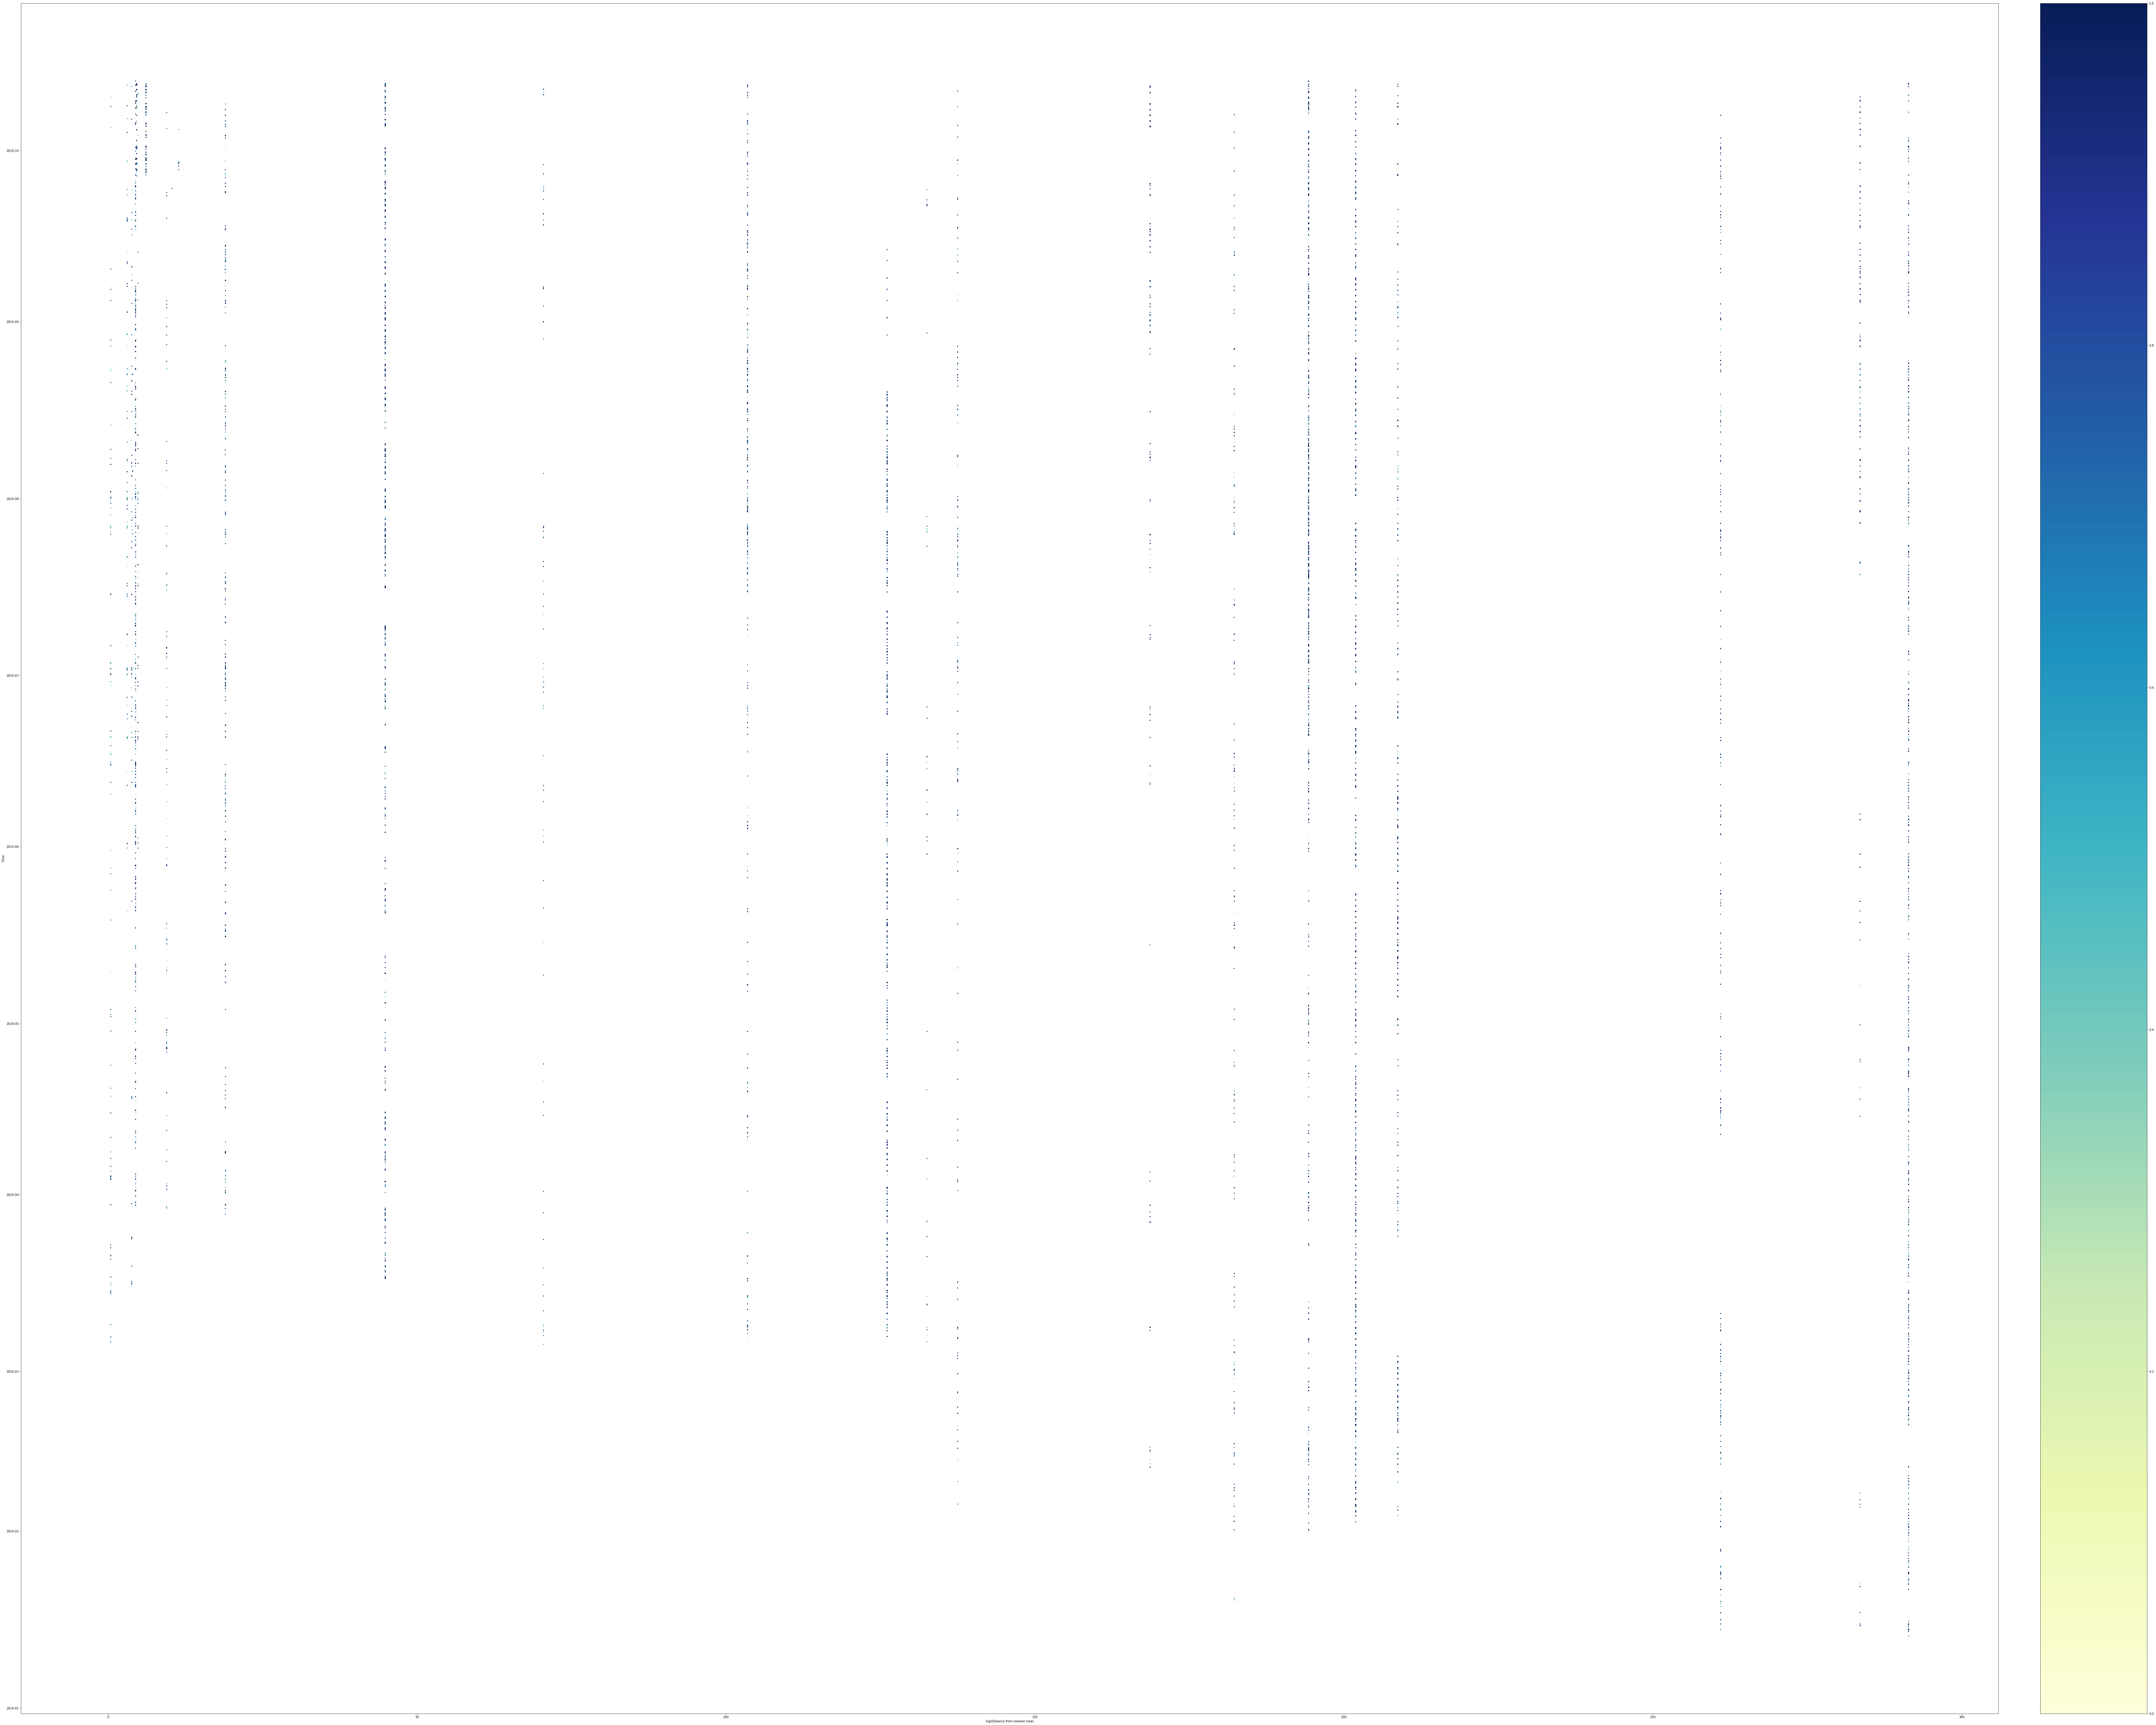

In [81]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib.ticker as plticker

from matplotlib import cm
import matplotlib as mpl

fig, axs = plt.subplots(1, 1, figsize=(100, 80), constrained_layout=True)


axs.scatter(X, Y,s=5, c = S, cmap='YlGnBu', vmin = 5.2, vmax =6.4)
fig.colorbar(cm.ScalarMappable(cmap='YlGnBu'), ax=axs)

# Major ticks every half year, minor ticks every month,
axs.set_ylabel(r'Time')
axs.set_xlabel(r'log(Distance from nearest road)')

In [ ]:
d= [x for x in list(set(X)) if np.isnan(x)==False]

In [115]:
from datetime import datetime

Y_timestamps=[]
for i in Y:
  Y_timestamps.append(datetime.timestamp(i)/10000000) # Normalising the timestamps


xy=np.array(list(zip(X,Y_timestamps)))
maxY=max(Y_timestamps)
minY=min(Y_timestamps)

In [116]:
resolution = 0.01

# Rescaling the unit of area so that our parameter estimates
# are easier to read
area_per_cell = resolution ** 2 / 100

cells_x = int(1 / resolution)
cells_y = int(1 / resolution)

# Creating bin edges for a 2D histogram
quadrat_y = np.linspace(minY, maxY, cells_y )

quadrat_xs=[]
for pos in d:
  quadrat_xs.append(np.linspace(pos-0.7, pos+0.7, 2 ))

# Merge all quadrat_x's into 1 numpy array
import itertools
merged = list(itertools.chain(*quadrat_xs))
quadrat_xs =np.sort(np.array(merged))

In [118]:
# x's for centroids(take each 1st value so that centroids are placed only at the x locations where points are present)
xs_for_centroids=[]
for i in range(len(quadrat_xs)):
  if (i+1)%2!=0:
    xs_for_centroids.append(quadrat_xs[i])

xs_for_centroids=np.sort(np.array(xs_for_centroids))

xs_for_centroids=np.append(xs_for_centroids,1000000)

In [119]:
from itertools import product

# Identifying the midpoints of each grid cell
centroids = np.asarray(list(product(xs_for_centroids[:-1]+0.8, quadrat_y[:-1]+0.0125)))

cell_counts, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [np.sort(xs_for_centroids), quadrat_y])
cell_counts = cell_counts.ravel().astype(int)

In [120]:
final_centroids=[]
observations=[]

for i in range(len(cell_counts)):
  if cell_counts[i] !=0:
    final_centroids.append(centroids[i])
    observations.append(cell_counts[i])

final_centroids=np.array(final_centroids)
observations=np.array(observations)

Text(0.5, 0, 'Distance from Kampala Center')

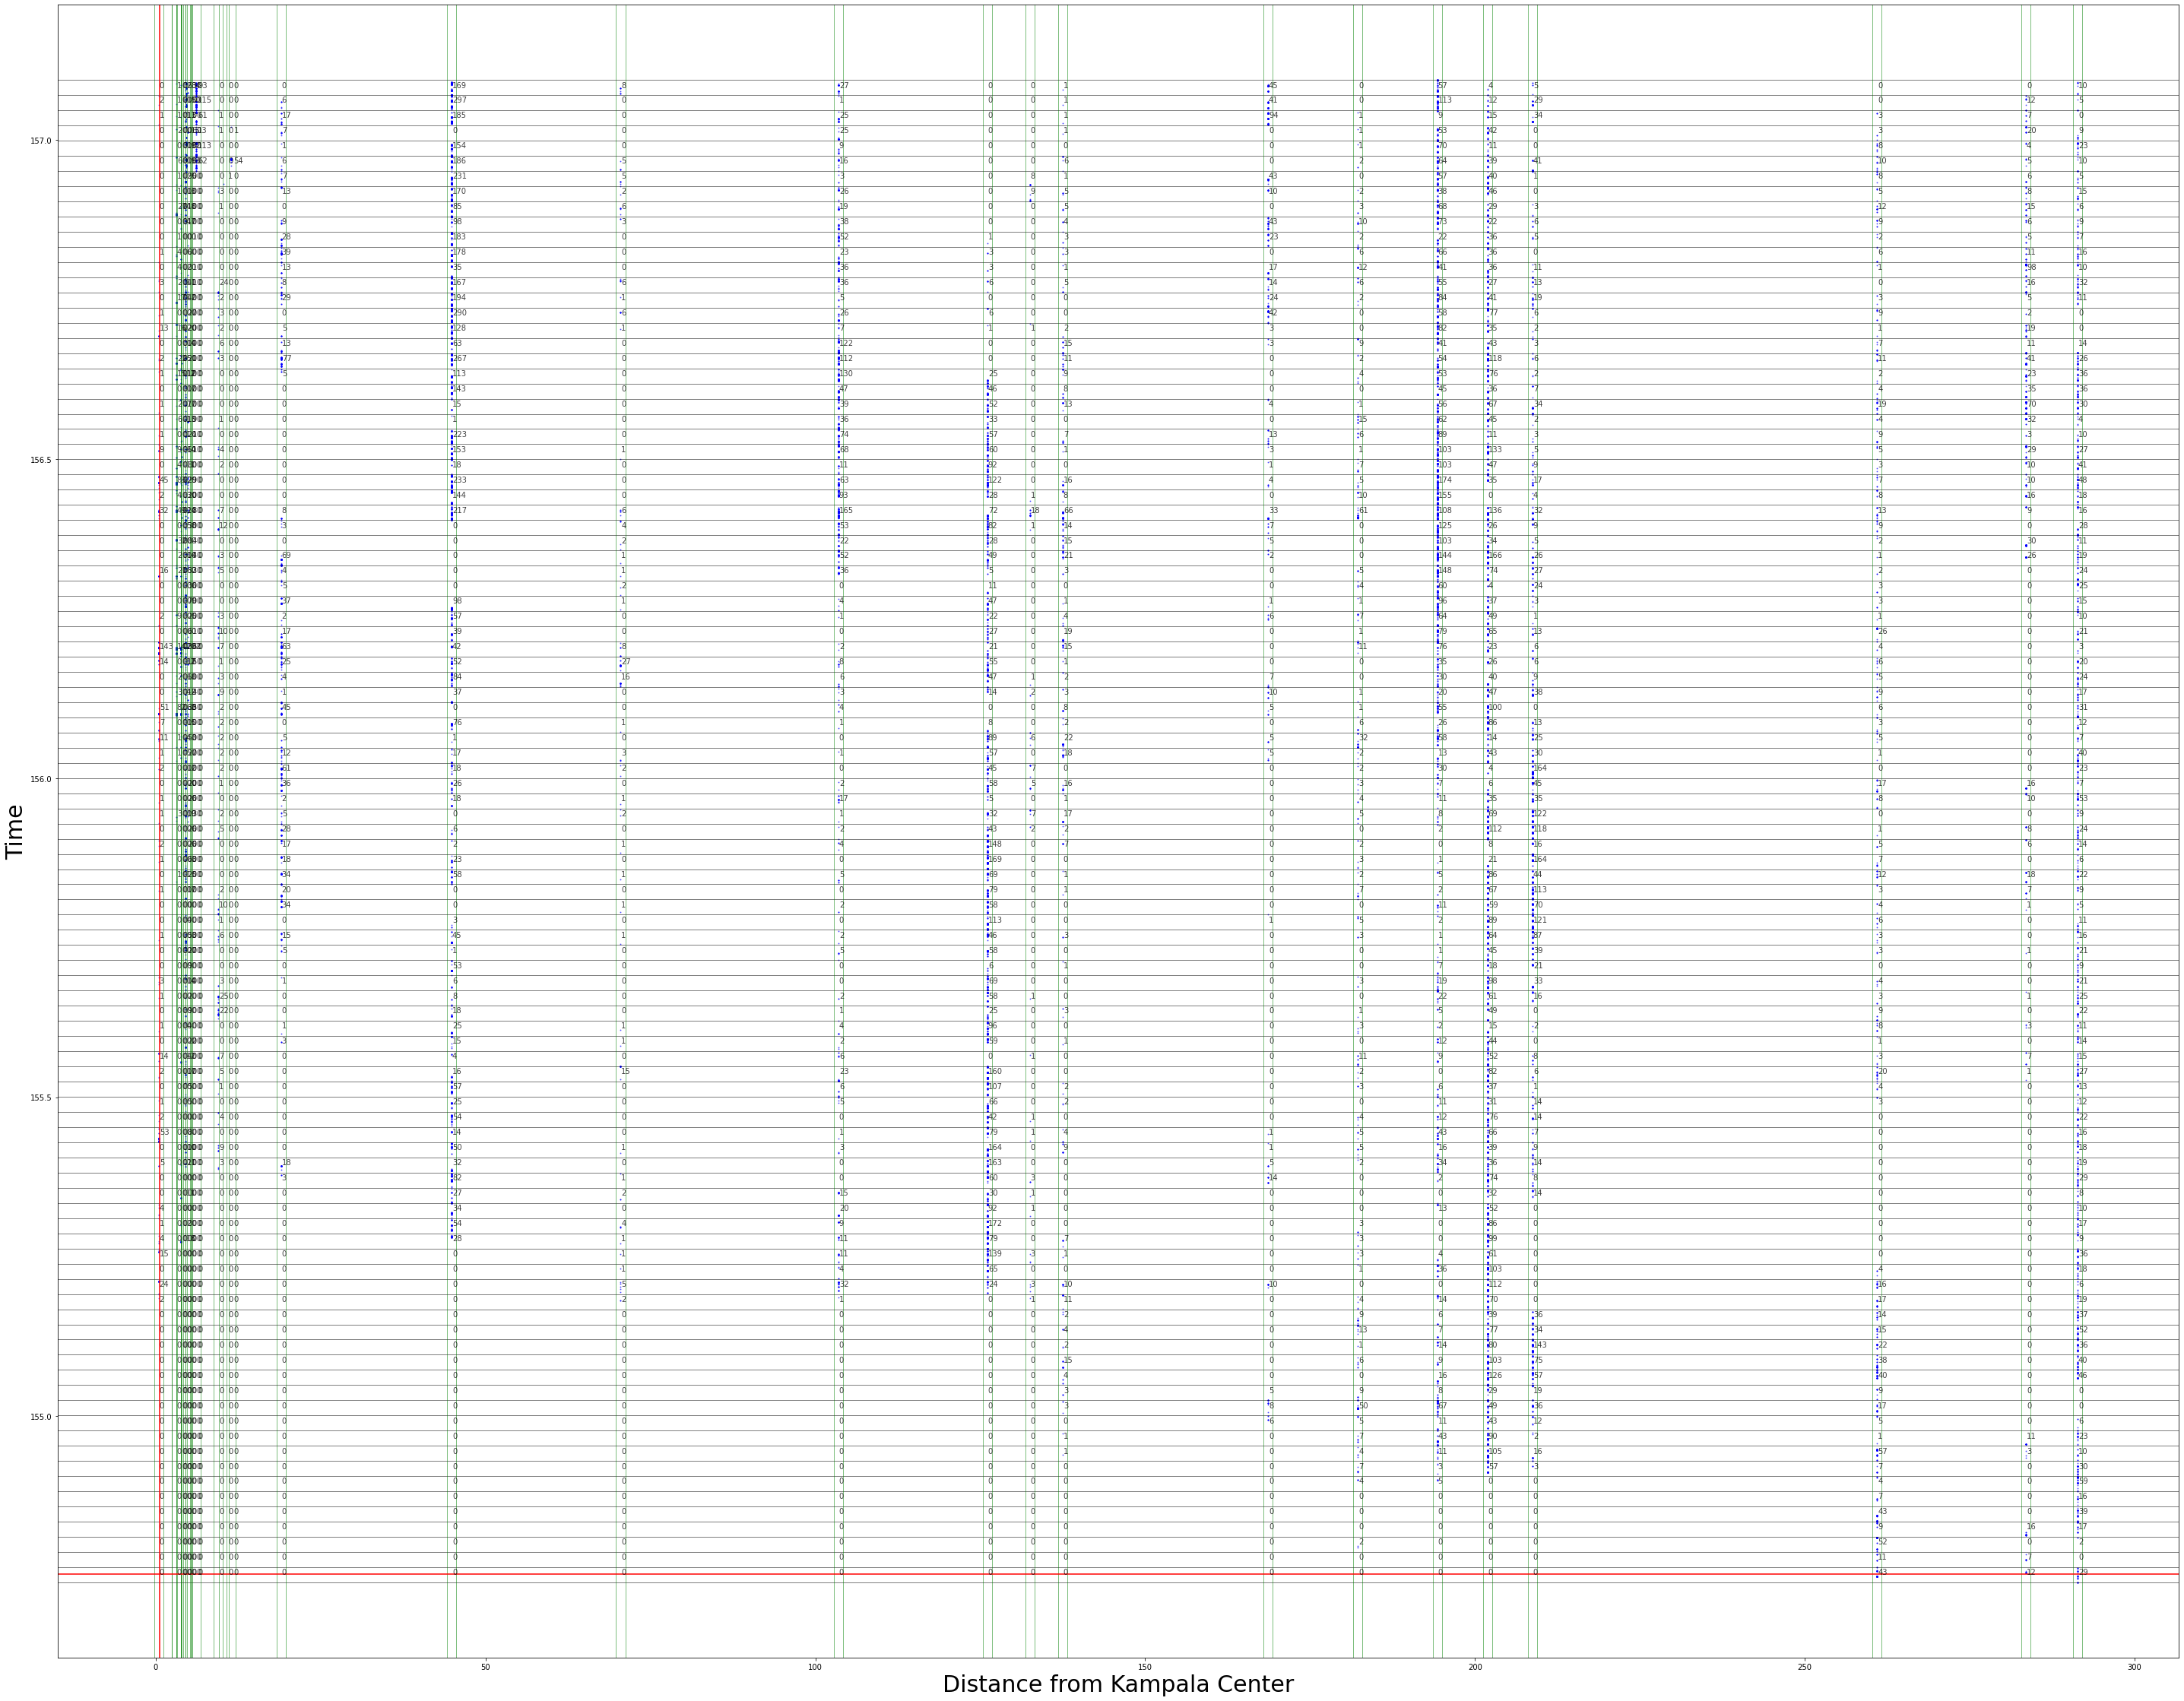

In [121]:
plt.rcParams['axes.facecolor'] = 'white'
h_line_kwargs = {"color": "k", "linewidth": 1, "alpha": 0.5}
v_line_kwargs = {"color": "g", "linewidth": 1, "alpha": 0.5}

plt.figure(figsize=(50,40))
[plt.axhline(y, **h_line_kwargs) for y in quadrat_y]
[plt.axvline(x, **v_line_kwargs) for x in quadrat_xs]

plt.scatter(arr1, Y_timestamps, s=1, c='blue',edgecolors='blue', alpha=0.5)
for i, row in enumerate(centroids):
    shifted_row = row
    plt.annotate(cell_counts[i], shifted_row, alpha=0.75, fontsize=10)

plt.axvline(centroids[0][0], color='r')
plt.axhline(centroids[0][1], color='r')

plt.ylabel(r'Time', fontsize=30)
plt.xlabel(r'Distance from Kampala Center', fontsize=30)

In [90]:
# Kernels
#cov_func_RatQuad = variance * pm.gp.cov.RatQuad(2,1,ls=0.3)
#cov_func_Exponential= variance * pm.gp.cov.Exponential(2, rho)
#cov_func_Matern= variance * pm.gp.cov.Matern52(2, rho)
#cov_func_periodic= variance*pm.gp.cov.Periodic(2,period=2,ls=rho)
#cov_func_LocalPeriodic=  cov_func_periodic*cov_func_Matern
"""
    mu = pm.Normal("mu", sigma=0.5)
    rho = pm.Uniform("rho", lower=10, upper=100)
    variance = pm.InverseGamma("variance", alpha=1, beta=1)
    cov_func_RatQuad = variance * pm.gp.cov.RatQuad(2,1,ls=rho)
    cov_func_Exponential= variance * pm.gp.cov.Exponential(2, rho)
    cov_func_Matern= variance * pm.gp.cov.Matern52(2, rho)
    cov_func_periodic= variance*pm.gp.cov.Periodic(2,period=2,ls=rho)
    cov_func_LocalPeriodic=  cov_func_periodic*cov_func_Matern
    mean_func = pm.gp.mean.Constant(mu)""";

In [91]:
# Build model
with pm.Model() as lgcp_model:
    mu = 0
    rho = 8
    variance = 1
    cov_func_RatQuad = variance * pm.gp.cov.RatQuad(2,1,ls=rho)
    mean_func = pm.gp.mean.Constant(mu)

with lgcp_model:
    # Create the GP object using MarginalSparse instead of Latent.
    # Approximation algorithm used is FITC.
    gp = pm.gp.MarginalSparse(cov_func=cov_func_RatQuad, mean_func = mean_func, approx='FITC') # Marginal sparse

    # initialize 10 inducing points with K-means
    # gp.util
    Xu = pm.gp.util.kmeans_inducing_points(10, centroids)
    
    # Noise to be passed as parameter to the marginal_likelihood method(version of .prior method for marginal
    # sparse implementation)
    σ = pm.Normal("σ", mu=10, sigma=2)
    
    # Place the prior over the function we want to model(the log intencity of the point process)
    # using the .marginal_likelihood method instead of the .prior method we used in the latent 
    # implementation. Parameters are the X training data, Xu inducing points, y observed data and noise sigma.
    log_intensity = gp.marginal_likelihood("log_intensity", X=centroids, Xu=Xu, y=cell_counts, noise=σ) # Sparse

    intensity = pm.math.exp(log_intensity)
    
    rates = intensity * area_per_cell
    # Poisson likelihood
    counts = pm.Poisson("counts", mu=rates, observed=cell_counts)

with lgcp_model:
    trace = pm.sample(5000, chains=4, tune=2000, target_accept=0.85, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [σ]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 101 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0002, but should be close to 0.85. Try to increase the number of tuning steps.
There were 9999 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0004, but should be close to 0.85. Try to increase the number of tuning steps.
There were 14999 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.85. Try to increase the number of tuning steps.
There were 19999 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.85. Try to increase the number of tuning step

Diagnosing biased inference with dibergences
https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html

In [92]:
x_new = x_new = np.linspace(0, 300, 40) # Create new entry points to apply the conditional and get prediction
y_new = np.linspace(154.5, 157.3, 40)
xs, ys = np.asarray(np.meshgrid(x_new, y_new))
xy_new = np.asarray([xs.ravel(), ys.ravel()]).T

with lgcp_model:
    # Perform inference 
    # The conditional method creates the conditional, or predictive distribution 
    # over the latent function at arbitrary X* input points(xy_new here), f(x*).
    intensity_new = gp.conditional("log_intensity_new", Xnew=xy_new)

    spp_trace = pm.sample_posterior_predictive(
        trace, var_names=["log_intensity_new"], keep_size=True
    )
    # Extend trace to include spp_trace
    trace.extend(
        az.from_dict(posterior_predictive=spp_trace, dims={"log_intensity_new": ["sample"]})

    )
    # The predicted intensity values we get after applying conditioning stored in a var.
    intensity_samples = np.exp(trace.posterior_predictive["log_intensity_new"]) 

Text(0.5, 1.05, '$\\lambda=15$, Exponential kernel')

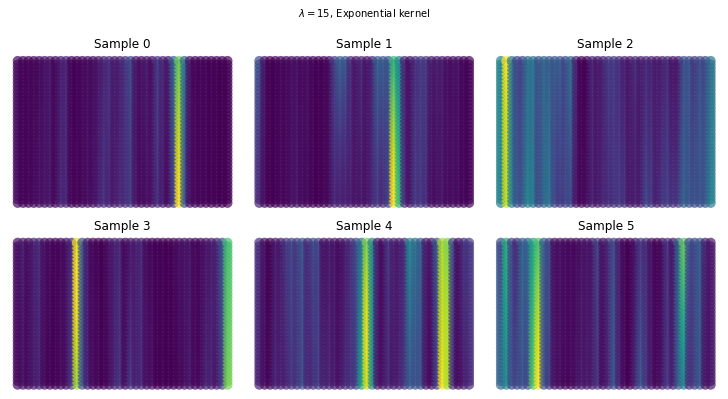

In [94]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5), constrained_layout=True)
axes = axes.ravel()

field_kwargs = {"marker": "o", "edgecolor": "None", "alpha": 0.7, "s": 100}

for i in range(6):
    # Plot 6 of the conditional samples
    field_handle = axes[i].scatter(
        xy_new[:, 0], xy_new[:, 1], c=intensity_samples.sel(chain=1, draw=i), **field_kwargs
    )

    obs_handle = axes[i].scatter([], [], s=0.1, color="k",alpha=1)
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i}")


fig.text(0.5, 1.05, '$\lambda=15$, Exponential kernel', ha='center')

Text(0.45, 0.95, '$\\lambda=15$, Exponential kernel')

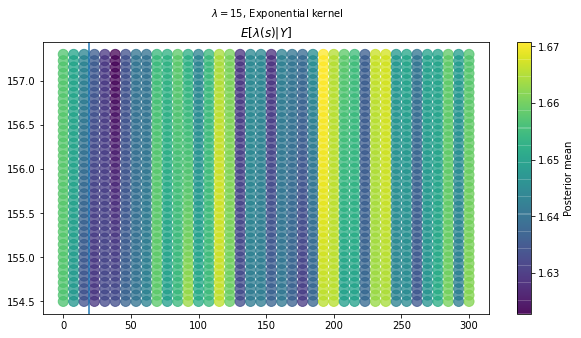

In [107]:
fig = plt.figure(figsize=(10, 5))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=intensity_samples.mean(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)

plt.title("$E[\\lambda(s) \\vert Y]$")
plt.colorbar(label="Posterior mean");

plt.axvline(x= 19.003930339150997)

fig.text(0.45, 0.95, '$\lambda=15$, Exponential kernel', ha='center')

Text(0.5, 0, 'Distance from Kampala Center')

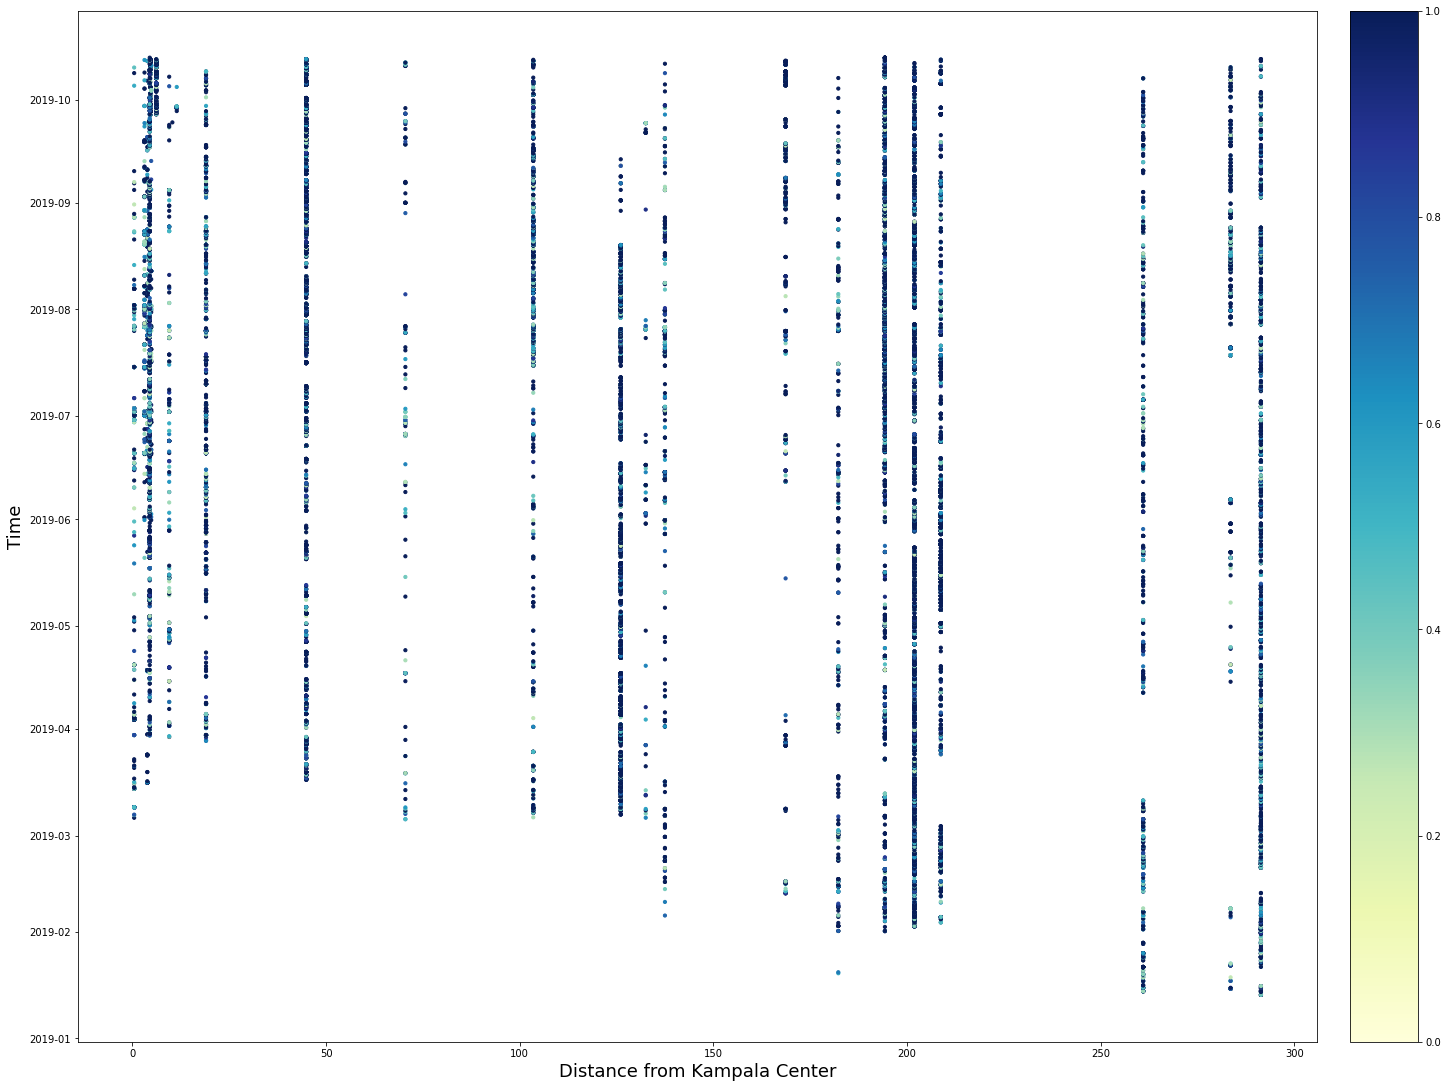

In [97]:
fig, axs = plt.subplots(1, 1, figsize=(20, 15), constrained_layout=True)
from matplotlib import cm

axs.scatter(X, Y,s=10, c = S, cmap='YlGnBu', vmin = 5.2, vmax =6.4)
fig.colorbar(cm.ScalarMappable(cmap='YlGnBu'), ax=axs)

# Major ticks every half year, minor ticks every month,
axs.set_ylabel(r'Time', fontsize=18)
axs.set_xlabel(r'Distance from Kampala Center', fontsize=18)